Enter URL for first page of thread:  https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/
Enter a name for the CSV file. Leave blank to not save:  
Enter number for which page of thread to start on. Leave blank to start on first page of thread.  
Enter number for which page of thread to end on. Leave blank to end on last page of thread.  
This csv already exists. Press Enter to append existing csv or run script again and choose a different name. 


1
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-1
2
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-2
3
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-3
4
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-4
5
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-5
6
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effects-as-a-result.355681/page-6
7
https://www.resetera.com/threads/if-sony-or-microsoft-acquired-nintendo-what-would-be-the-overall-reaction-and-effec

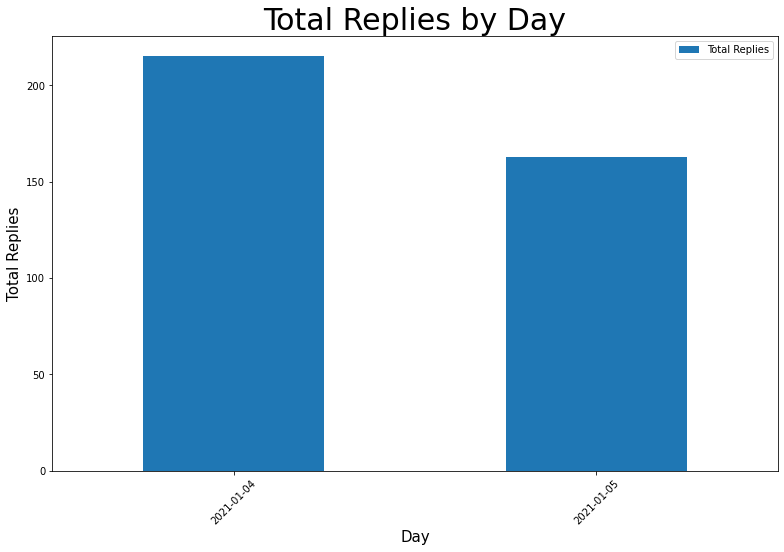

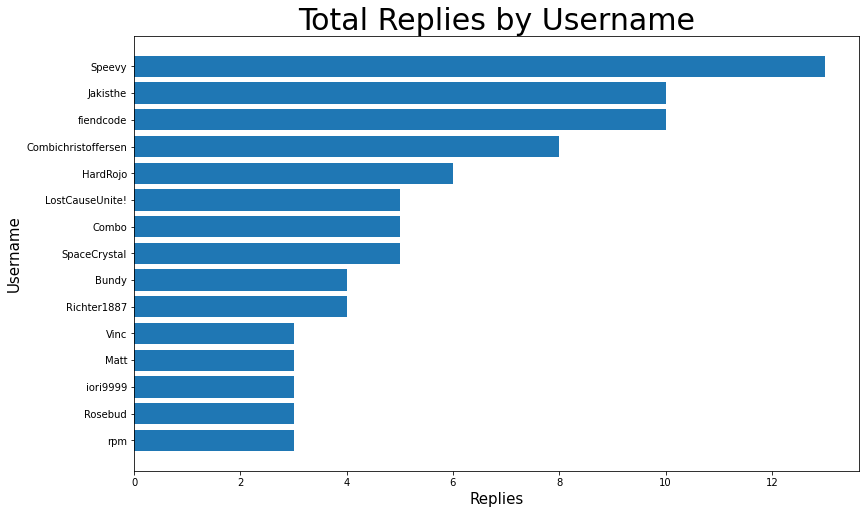

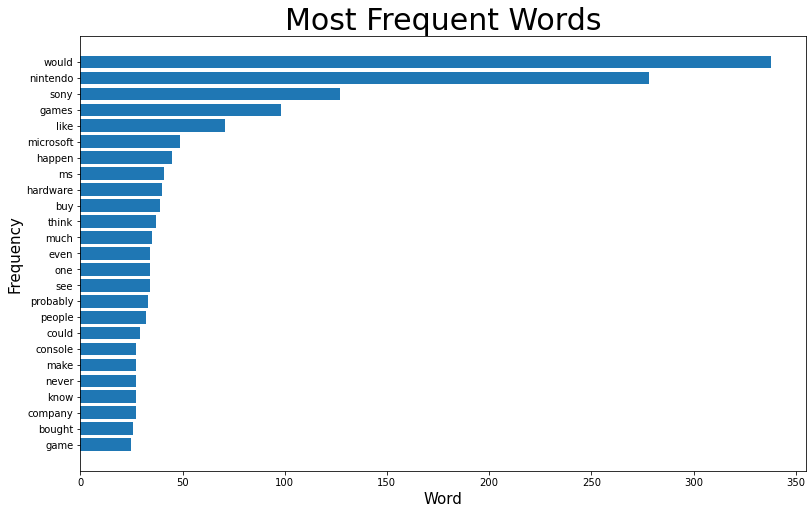

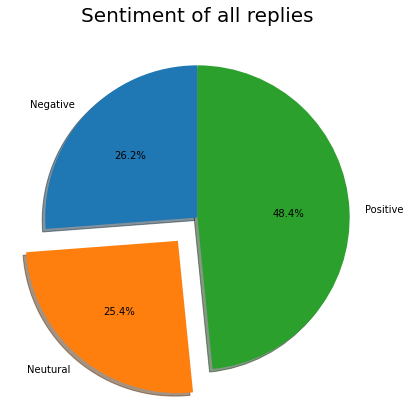

,Sentiment,Total Sentiment
0,Negative,99
1,Neutural,96
2,Positive,183


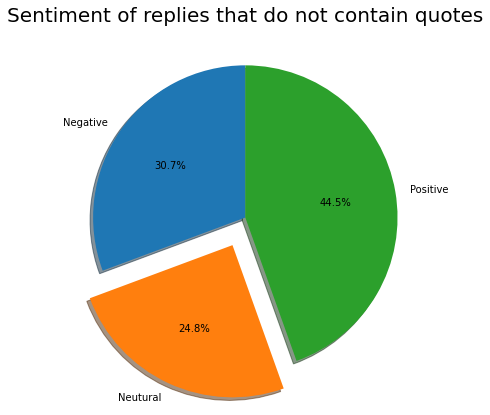

,Sentiment,Total Sentiment
0,Negative,73
1,Neutural,59
2,Positive,106


,Username,Date_Time,Score,Quoted,Sentiment,Replies
0,Shiba,2021-01-04 18:37:23,-0.5845,Not Quoted,Negative,"Would you view it as a negative or positive?How would it change the industry at large?What changes do you expect happen to Nintendo as a result?Curious on what y’all thoughts are on this. The Bethesda acquisition was definitely huge, but a console publisher acquiring another console publisher is pure craziness."
1,J Snow,2021-01-04 18:38:00,0.0216,Not Quoted,Neutural,I would make a face like this :O
2,FaultLineBlues,2021-01-04 18:38:15,-0.2960,Not Quoted,Negative,"My mind would probably fizzle out from confusion, for starters."
3,solidr,2021-01-04 18:38:43,-0.1027,Not Quoted,Negative,:O
4,--R,2021-01-04 18:38:45,-0.2960,Not Quoted,Negative,Would never happen. Laws in place would stop it from happening.
5,Jimmy Joe,2021-01-04 18:39:08,0.3736,Not Quoted,Positive,"Doesn't Nintendo have a market cap of like 60 billion USD or some such ignorantly huge numberMy first reaction would be ""Wait, how did happen? What? Are you"
6,TeraDax,2021-01-04 18:39:15,-0.0258,Not Quoted,Neutural,That would make me sad. And others too I guess.Some weird people would be happy too probably.
7,Renna Hazel,2021-01-04 18:39:34,-0.6240,Not Quoted,Negative,"Being that Nintendo is my primary platform I would view that as very negative. I assume Nintendo would do well under Sony, not under MS based on history. If it goes south, I'd likely stop gaming as a main hobby."
8,Rosebud,2021-01-04 18:39:55,0.0000,Not Quoted,Neutural,MS: Xbox and PC fanboys happySony: PS fanboys happyEveryone else:
9,tyraniboah,2021-01-04 18:40:42,-0.5574,Not Quoted,Negative,"I don’t even know why this is a thread. It would literally never happen. Microsoft will leave console gaming altogether before Nintendo allows themselves to get purchased.But if it did, it would absolutely lead to a bunch of salt and hurt feelings"


In [2]:
#nltk.download('vader_lexicon')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords  
import nltk
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bs4 as bs
import numpy as np
import pandas as pd
import requests
from pandas import DataFrame
import csv
from datetime import datetime
import time
import pathlib

#Dataframes will be fully visible when printing
pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)

sid = SentimentIntensityAnalyzer()

forum_thread_page_num = 1

#User can enter which page to of thread to start collecting information on 
url_link = input("Enter URL for first page of thread: ").rstrip()
file_name = input("Enter a name for the CSV file. Leave blank to not save: ").rstrip() 

#User can enter which page of thread to start collecting infrmation on
starting_page = input("Enter number for which page of thread to start on. Leave blank to start on first page of thread. ").rstrip()
if starting_page != '':
    starting_page = int(starting_page)
    forum_thread_page_num = starting_page
    
#User can enter which page of thread to stop collecting infrmation on
ending_page = input("Enter number for which page of thread to end on. Leave blank to end on last page of thread. ").rstrip()
if ending_page == '':
    ending_page = float('inf')
else:
    ending_page = int(ending_page)
    
#create the csv with headers if csv does not already exist
csv_file_path = pathlib.Path(file_name +'.csv')
if csv_file_path.exists():
    input("This csv already exists. Press Enter to append existing csv or run script again and choose a different name.")
else:
    csv_header_df = pd.DataFrame(columns = ['Name', 'Date_Time', 'Score', 'Quote', 'Sentiment', 'Reply'])
    csv_header_df.to_csv(csv_file_path, index = False, mode = "a", header=True, encoding='utf-8-sig')


df2 = pd.DataFrame()


while True:
    time.sleep(1)
    url = url_link + 'page-' + str(forum_thread_page_num)
    print(forum_thread_page_num)
    print(url)
    request = requests.get(url)
    response = request.text 
    soup = bs.BeautifulSoup(response, 'lxml')

    #create list of usernames so that they can later be matched to comments 
    username_list = []
    username = soup.findAll("a", {"itemprop": "name"})
    for name in username:
        new_name = name.get_text()
        username_list.append(new_name)
        
    #find the date & time
    date_soup = soup.findAll('div', {'class': 'message-attribution-main'})
    date_time_list = []
    #date and time is found in the '<time>' tag. In the time tage there is a variable called "datetime" that is = to 
    #date of the post and formatted as '2020-09-24T18:28:56-0400', I store this datetime as a list object and slice it
    #so that I get only '2020-09-24 18:28:56 date_time.
    for item in date_soup:
        date_time = item.find('time').attrs['datetime'][0:19]
        date_time_list.append(date_time)
    #find the comments 
    comments = soup.findAll("div", {"class": "bbWrapper"})

    #Replies that quote other users will contain ("div", {"class": "bbCodeBlock-expandContent"}). If this is found
    #'Quote' is added to the quote_reply_list Else: Not Quoted is addded to list. 
    #To access commment, return only the text from the comments. 'recursive=False' prevents parsing any sub-tags. All needed text is a 
    #direct child of -> "div", {"class": "bbWrapper"}
    comment_list = []
    quote_reply_list = []
    for comment in comments:
        replies_to_quotes = comment.find_all("div", {"class": "bbCodeBlock-expandContent"})
        if len(replies_to_quotes) > 0:
            quoted_or_not = "Quote"
        else:
            quoted_or_not = "Not Quoted" 
        quote_reply_list.append(quoted_or_not)
    
        comment=comment.find_all(text=True, recursive=False)
        comment = ''.join(comment) #convert list to string
        comment = comment.replace('\n', '') #remove new lines for paragraphs(Combines multiple paragraphs to one)
        if not comment: #if comment is empty
            comment = 'N/A'
        comment_list.append(comment)

    #use sentimentAnalyzer for each comment and create list of the 'compound' score for each comment
    compound_result_list = []
    for comment in comment_list:
        sentiment_result_dict = sid.polarity_scores(comment)
        compound_result = sentiment_result_dict.get('compound')
        compound_result_list.append(compound_result)
    
    #Iterate through the compound_result list to determine whether each score is pos. neut. or neg. Then append this
    #to the sentiment list
    sentiment_list = []
    for score in compound_result_list:
        if score <= -0.05:
            sentiment = "Negative"
        elif score > -0.05 and score < 0.05:
            sentiment = "Neutural"
        elif score >= 0.05:
            sentiment = "Positive"
        sentiment_list.append(sentiment)
    
    #combine five lists and convert to DataFrame w
    new_dict = zip(username_list, date_time_list, compound_result_list, quote_reply_list, sentiment_list, comment_list)
    df = DataFrame(new_dict)
    df2 = df2.append(df)
    
    #if there are less than 50 usernames it means it is the last page and should break
    if len(username_list) < 50 or forum_thread_page_num == ending_page:
        #Rename the columns of the dataframe
        df2.rename(columns={0: "Username", 1: "Date_Time", 2: "Score", 3: "Quoted", 4: "Sentiment", 5: "Replies"}, inplace=True)
        #Convert date & time columns from string to datetime objects so that they can be manipulated with pandas
        df2["Date_Time"] = pd.to_datetime(df2["Date_Time"], format="%Y-%m-%d %H:%M:%S")
           
        print("\n--------------------\nTotal Replies: ", df2["Username"].count(), "\n--------------------")
        
        #####Total Replies on a date in Chron order#####  
        #Groupby Day using freq='D' and then find the size() and add it to the column Total Replies which will tally the total replies for each day.
        #convert the .size() series that it returns to a dataframe using .reset_index. Convert DateTime object to just date using strftime. if there is only one date worth of replies,
        #use the if statement to group by hours instead to display hourly data for the single day. Else groupby day and show daily Total Replies.
        df4 = df2.set_index("Date_Time").groupby(pd.Grouper(freq='D')).size().reset_index(name='Total Replies')
        df4["Date_Time"] = (df4["Date_Time"].dt.strftime('%Y-%m-%d'))
        #This date will be the x-axis title if there is only one day of Replies
        xlabel_date = str(df4["Date_Time"][0])
        if len(df4["Date_Time"]) == 1:
            df4 = df2.set_index("Date_Time").groupby(pd.Grouper(freq='H')).size().reset_index(name='Total Replies')
            df4["Date_Time"] = (df4["Date_Time"].dt.strftime('%H:%M:%S'))
            #I am calling .plot on the Dataframe using pandas. This method references the Matplot API
            df4.set_index("Date_Time").plot.bar(figsize=(13, 8))
            plt.xlabel(xlabel_date + " (Hourly)", fontsize=15)
            plt.title("Total Replies by Hour",fontsize=30, color="Black")
        else:
            df4.set_index("Date_Time").plot.bar(figsize=(13, 8))
            plt.xlabel("Day", fontsize=15)
            plt.title("Total Replies by Day",fontsize=30, color="Black")
        plt.ylabel("Total Replies", fontsize=15)
        plt.xticks(rotation=45)
        #limit the number of x axis labels using 'nbins='
        plt.locator_params(axis='x', nbins=13)
        plt.show()
        ###########
        
        #####Total Replies by a user#####
        #Use groupby to group by Username, then use .size() to return a series that will show
        #the total number for each username. Convert this to a dataframe using .reset_index()
        df3 = df2.groupby(["Username"]).size().reset_index(name='Total Replies') 
        #Sort the dataframe users with least replies to greatest replies then get the tail which will have users with the most posts. 
        #Do this because if the bar chart goes from gretest to least, the bar chart will be upside down when plotted in matplot.
        df3.sort_values(by=['Total Replies'], inplace=True, ascending=True)
        df3 = df3.tail(15)
        #matplot
        plt.figure(figsize=(13,8))
        plt.barh(df3["Username"], df3["Total Replies"])
        plt.xlabel("Replies", fontsize=15)
        plt.ylabel("Username", fontsize=15)
        plt.title("Total Replies by Username", fontsize=30)
        plt.show()
        ###########
        ##Sentiment of top Users##
#         for username in reversed(username_labels):
#             individual_username_setniment_df = df2[""]

        ##Word Frequencies##
        #make everything lower case then tokenize
        lower_case_replies_df = df2['Replies'].str.lower().str.cat(sep=' ')
        tokenized_replies_list = nltk.tokenize.word_tokenize(lower_case_replies_df)
        #remove stop words
        stop_words = set(stopwords.words('english'))
        replies_with_no_stop_words_list = []
        for word in tokenized_replies_list:
            if word not in stop_words:
                replies_with_no_stop_words_list.append(word)
        #remove punctuation
        cleaned_text_list = []
        for word in replies_with_no_stop_words_list:
            if word.isalpha():
                cleaned_text_list.append(word)
        word_dist = nltk.FreqDist(cleaned_text_list)
        top_words = 25
        df_top_words = pd.DataFrame(word_dist.most_common(top_words), columns=['Word', 'Frequency'])
        #sort from least to greatest otherwise barchart will be upside down
        df_top_words.sort_values(by=['Frequency'], inplace=True, ascending=True)
        #matplot
        plt.figure(figsize=(13,8))
        plt.barh(df_top_words["Word"], df_top_words["Frequency"])
        plt.xlabel("Word", fontsize=15)
        plt.ylabel("Frequency", fontsize=15)
        plt.title("Most Frequent Words", fontsize=30)
        plt.show()
        
        #####Sentiment neg, neut, pos#########
        #groupby the sentiment column (pos. neg. neut.) add up each a create the total sentiment column
        #Visualize Sentiment in pie chart
        ###sentiment with and without quotes section##
        sentiment_labels = ["Negative", "Neutural", "Positive"]
        df_sentiment_with_quotes = df2.groupby(["Sentiment"]).size().reset_index(name="Total Sentiment")  
        total_sentiment_with_quotes = df_sentiment_with_quotes["Total Sentiment"].tolist()
        plt.figure(figsize=(7,7))
        plt.pie(total_sentiment_with_quotes, labels = sentiment_labels, explode = (0, 0.2, 0), shadow = True, startangle = 90, autopct='%1.1f%%')
        plt.title("Sentiment of all replies", fontsize = 20)
        plt.show()
        display(df_sentiment_with_quotes) 
        
        ##Sentiment with out quotes section##
        #groupby the sentiment column (pos. neg. neut.) add up each a create the total sentiment column, but do no include replies
        #that have quotes from other users in them because this could impact sentiment to the thread title
        df_no_quotes = df2[df2["Quoted"]=="Not Quoted"]
        df_sentiment_no_quotes = df_no_quotes.groupby(["Sentiment"]).size().reset_index(name="Total Sentiment") 
        total_sentiment_no_quotes = df_sentiment_no_quotes["Total Sentiment"].tolist()
        plt.figure(figsize=(7,7))
        plt.pie(total_sentiment_no_quotes, labels = sentiment_labels, explode = (0, 0.2, 0), shadow = True, startangle = 90, autopct='%1.1f%%')
        plt.title("Sentiment of replies that do not contain quotes", fontsize = 20)
        plt.show()
        display(df_sentiment_no_quotes)
        ##########
                     
        #Write dataFrame to csv in append mode with the header removed
        df2.to_csv(csv_file_path, index = False, mode = "a", header=False, encoding='utf-8-sig')
        display(df2)
         
        break
    else:
        forum_thread_page_num = forum_thread_page_num + 1

#positive sentiment: compound score >= 0.05
#neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
#negative sentiment: compound score <= -0.05